In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
#import gensim
from itertools import product
import networkx as nx
from pagerank import *
#from drazin import *

%matplotlib inline

# Make team dictionary

In [ ]:
fd = pd.read_csv('FanGraphs_Fielders.csv')
bat = pd.read_csv('FanGraphs_Batting.csv')

fd = pd.merge(fd, bat, on=['Season', 'playerid', 'Name'])
teams = fd.Team_x.unique()

In [ ]:
#dct = {k:fd[fd.Team_x==k]['Team_y'].values[1] for k in teams}

## Create single DataFrame

In [ ]:
dct = {'- - -': '- - -',
 'ANA': 'Angels',
 'ARI': 'Diamondbacks',
 'ATL': 'Braves',
 'BAL': 'Orioles',
 'BOS': 'Red Sox',
 'CHC': 'Cubs',
 'CHW': 'White Sox',
 'CIN': 'Reds',
 'CLE': 'Indians',
 'COL': 'Rockies',
 'DET': 'Tigers',
 'FLA': 'Marlins',
 'HOU': 'Astros',
 'KCR': 'Royals',
 'LAA': 'Angels',
 'LAD': 'Dodgers',
 'MIA': 'Marlins',
 'MIL': 'Brewers',
 'MIN': 'Twins',
 'MON': 'Expos',
 'NYM': 'Mets',
 'NYY': 'Yankees',
 'OAK': 'Athletics',
 'PHI': 'Phillies',
 'PIT': 'Pirates',
 'SDP': 'Padres',
 'SEA': 'Mariners',
 'SFG': 'Giants',
 'STL': 'Cardinals',
 'TBD': 'Devil Rays',
 'TBR': 'Rays',
 'TEX': 'Rangers',
 'TOR': 'Blue Jays',
 'WSN': 'Nationals'}

In [ ]:
years = list(range(2002,1+2016))

sp = pd.read_csv('FanGraphs_Starters.csv')# ,index_col=['playerid','Season'])#;print(sp.sample(3))
rp = pd.read_csv('FanGraphs_Relievers.csv')#,index_col=['playerid','Season'])
fd = pd.read_csv('FanGraphs_Fielders.csv')#,index_col=['playerid','Season'])
bat = pd.read_csv('FanGraphs_Batting.csv')#,index_col=['playerid','Season'])

fd.loc[[True]*len(fd),'Team'] = [dct[k] for k in fd.Team]#;print(fd.sample(3))

fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])

mask1 = fd.Seasonid.isin([tuple(row) for row in sp[['playerid','Season']].values])
print('fd',len(fd),'mask',len(mask1))
fd.drop(fd[mask1].index,inplace=True)

mask2 = fd.Seasonid.isin([tuple(row) for row in rp[['playerid','Season']].values])
print('fd',len(fd),'mask',len(mask2))
fd.drop(fd[mask2].index,inplace=True)

fd.drop('Seasonid',axis=1,inplace=True)
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'
print(fd.sample(4))
sp.insert(2, 'Pos', 'P')
rp.insert(2,'Pos', 'P')
p = pd.concat([sp,rp,fd], ignore_index=True)
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
#p.drop(p[p.Team=='- - -'].index,inplace=True)
p.drop(p[p.Season<2002].index,inplace=True)
p.reset_index()
del(dct['MON'])
del(dct['TBD'])
#del(dct['- - -'])
teams = dct.values()

print('p',len(p))
player_cnts = Counter(p.playerid)
p.drop_duplicates(inplace=True)
#for pid in sp['playerid']:
#    mask = (sp['playerid']==pid)&(sp['Team']=='- - -')

In [ ]:
p.insert(1, 'Change_Type', 'No Change')

In [ ]:
(one_player.Season==y)

In [ ]:
by_player = p.groupby('playerid')
for g in by_player.groups:
    one_player = by_player.get_group(g)
    #if sum(one_player['Team']=='- - -'):
    #    print(by_player.get_group(g).sort_values('Season'), end='\n\n')
    #if g in range(100,200): break
    
    for y in sorted(one_player['Season'])[1:]:
        #print(y)
        if sum(one_player.Season==y-1)==0: continue
        #print(pid, y)
        #print(p[(p.playerid==pid) * (p.Season==y)].Team.values[0])
        #print(p[(p.playerid==pid) * (p.Season==y-1)].Team.values[0])
        #print(one_player[one_player.Season==y].index)
        if one_player[(one_player.Season==y)].Team.values[0] != one_player[(one_player.Season==y-1)].Team.values[0]:
            if one_player[(one_player.Season==y-1)]['Change_Type'].values[0] == 'Arrive':
                p.loc[one_player[one_player.Season==y-1].index,'Change_Type'] = 'Arrive Leave'
                p.loc[one_player[one_player.Season==y].index,'Change_Type'] = 'Arrive'

            else:
                p.loc[one_player[one_player.Season==y-1].index,'Change_Type'] = 'Leave'
                p.loc[one_player[one_player.Season==y].index,'Change_Type'] = 'Arrive'

In [ ]:
p.sort_values(by=['playerid', 'Season'], inplace =True)
prev_team = ''
prev_pid = -1
prev_chg = ''
prev_ixd = 1
for idx, (name, chg, pos, season, team, pid) in zip(p.index,p.values):
    if pid == prev_pid:
        if team == '- - -':
            p.loc[idx, 'Team'] == prev_team
            team = prev_team
        if team != prev_team:
            if prev_chg == 'No Change':
                p.loc[prev_idx, 'Change_Type'] = 'Leave'
            else:
                p.loc[prev_idx, 'Change_Type'] = 'Arrive Leave'
            p.loc[idx, 'Change_Type'] = 'Arrive'
            prev_chg = 'Arrive'
        else:
            prev_chg = 'No Change'
    else:
        p.loc[idx, 'Change_Type'] = 'Arrive'
        prev_chg = 'Arrive'
    prev_team = team
    prev_pid = pid
    prev_idx = idx

In [ ]:
p

In [ ]:
p[p.Change_Type!='Arrive Leave'].sort_values(by=['playerid', 'Season'])

In [ ]:
p.to_csv('combined_cleaned.csv')

## Analyze/Visualize Data

In [ ]:
print('P count:',sum(p.Pos=='P'))
p[p.Name=='Doug Waechter']

In [ ]:
print('Year|Player Count')
for i in years:
    print(i,len(p[p.Season==i]['playerid'].unique()))

In [ ]:
teams = p.groupby(['Team','Season'])

In [ ]:
print('  Year-->\t 02  03  04  05  06  07  08  09  10  11  12  13  14  15  16')
for t in dct.values():
    print('{:13}\t'.format(t),end='')
    for y in years:
        #print((t,y))
        try:
            print('{:3}'.format(len(teams.get_group((t,y)))),end=' ')
        except:
            print(' **',end=' ')
    print()

In [ ]:
by_year = p.groupby(['Season'])
#print(by_year.groups)
prev = Counter(by_year.get_group(years[0]).Pos)
for i in years[1:]:
    c = Counter(by_year.get_group(i).Pos)
    dif = c.copy()
    dif.subtract(prev)
    prev = c
    plt.bar(range(len(dif.values())),dif.values())
    plt.xticks(range(len(dif)),dif)
    plt.show()

In [ ]:
pd.options.display.max_rows = 200
print(p.pivot_table(values='playerid', index=['Season','Team'],columns='Pos', aggfunc='count', fill_value='-'))

In [ ]:
c = Counter(p[p.Team=='- - -'].Pos)
plt.bar(range(len(c.values())),[v/sum(p.Pos==k) for k,v in c.items()])
plt.xticks(range(len(c)),c)
plt.show()

## NLP Approach to Roles

In [ ]:
teams = list(dct.values())
by_season_team = p.groupby(['Season','Team'])
def sentence_gen(season, team, num=50):
    return [' '.join(map(str,np.random.permutation(by_season_team.get_group((season,team))['playerid']))) \
            for _ in range(num)]
    

In [ ]:
len(teams)*len(years)

In [ ]:
texts = []
for y,t in product(years,teams):
    texts.extend(sentence_gen(y,t,num=300))

In [ ]:
#dictionary = gensim.corpora.Dictionary(texts)

In [ ]:
p[p.Pos=='C'].sample(3)

In [ ]:
model = gensim.models.word2vec.Word2Vec(texts)

In [ ]:
model.train(texts, total_examples=model.corpus_count, epochs=model.iter)

In [ ]:
model.wv.n_similarity('514','4293')

In [ ]:
model.wv.n_similarity('2041','4293')

In [ ]:
model.wv.n_similarity('454','889')

In [ ]:
p[p.Pos=='FD'].sample(3)

In [ ]:
comp = []
for _ in range(5000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'P' and players.Pos.values[1] == 'P':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
for x,y in sorted(comp,key=lambda x: x[1]):
    pass
    #print('{}\t{:.4f}'.format(x,y))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('PP');plt.show()

comp = []
for _ in range(5000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'P' and players.Pos.values[1] == 'FD':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('PF');plt.show()

comp = []
for _ in range(12000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'P' and players.Pos.values[1] == 'C':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('PC');plt.show()

comp = []
for _ in range(16000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'C' and players.Pos.values[1] == 'C':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('CC');plt.show()

comp = []
for _ in range(12000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'C' and players.Pos.values[1] == 'FD':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('CF');plt.show()

comp = []
for _ in range(3000):
    players = p.sample(2)
    id1,id2 = players.playerid.values
    if players.Pos.values[0] == 'FD' and players.Pos.values[1] == 'FD':
        comp.append((players.Pos.values,model.wv.n_similarity(str(id1),str(id2))))
print(len(comp))
plt.hist([y for x,y in comp]);plt.title('FF');plt.show()

In [ ]:
years = sorted(p.Season.unique())
ind_yr = {y:i for i,y in enumerate(years)}
num_indiv = 30
player_gen = np.zeros((num_indiv,len(years)))

pids = np.random.permutation(p.playerid.values)[:num_indiv]
print(pids)
p[p['playerid'].isin(pids)]

In [ ]:
pos = []
for i,pid in enumerate(pids):
    player_hist = p[p['playerid']==pid]
    pos.append(player_hist['Pos'].values[0])
    #print(player_hist)
    for j,year in enumerate(range(start_y,1+end_y)):
        if year in player_hist['Season'].values:
            player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]
                
s = '''for i,pid in enumerate(pids):
    if pid in sp['playerid'].values:
        player_hist = sp[sp['playerid']==pid]
        print(player_hist)
        for j,year in enumerate(range(start_y,1+end_y)):
            if year in player_hist['Season'].values:
                player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]

    elif pid in rp['playerid'].values:
        player_hist = rp[rp['playerid']==pid]
        print(player_hist)
        for j,year in enumerate(range(start_y,1+end_y)):
            if year in player_hist['Season'].values:
                player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]
    
    elif pid in fd['playerid'].values:
        player_hist = fd[fd['playerid']==pid]
        print(player_hist)
        for j,year in enumerate(range(start_y,1+end_y)):
            if year in player_hist['Season'].values:
                player_gen[i,j] = ind_t[ player_hist[player_hist['Season']==year]['Team'].values[0] ]'''
    

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(player_gen, cmap='rainbow')
plt.yticks(range(num_indiv), pos)
plt.show()

## Finding Change Data

In [ ]:
p.insert(1, 'Change_Type', 'No Change')
for y in years[1:]:
    for pid in p[p.Season==y].playerid:
        if sum((p.playerid==pid) & (p.Season==y-1))==0: continue
        #print(pid, y)
        #print(p[(p.playerid==pid) * (p.Season==y)].Team.values[0])
        #print(p[(p.playerid==pid) * (p.Season==y-1)].Team.values[0])
        if p[(p.playerid==pid) & (p.Season==y)].Team.values[0] != p[(p.playerid==pid) & (p.Season==y-1)].Team.values[0]:
            if p[(p.playerid==pid) & (p.Season==y-1)]['Change_Type'].values[0] == 'Arrive':
                p.loc[(p.playerid==pid) & (p.Season==y-1),'Change_Type'] = 'Arrive Leave'
                p.loc[(p.playerid==pid) & (p.Season==y),'Change_Type'] = 'Arrive'

            else:
                p.loc[(p.playerid==pid) & (p.Season==y-1),'Change_Type'] = 'Leave'
                p.loc[(p.playerid==pid) & (p.Season==y),'Change_Type'] = 'Arrive'
p.sample(20)

In [ ]:
p.to_csv('combined_players_changes.csv')

In [ ]:
a = np.arange(30).reshape((5,6))
a = np.random.random((5,6))
u,s,v = np.linalg.svd(a)

In [ ]:
u

In [ ]:
s

In [ ]:
v

In [ ]:
u.shape

In [ ]:
rank = 5
s[s<0.00001] = 0

In [ ]:
v.shape

In [ ]:
np.rank(a)

In [ ]:
idx = np.diag_indices(min(a.shape))
sigma = np.zeros_like(a)
sigma[idx] = s

In [ ]:
np.allclose(u.dot(sigma.dot(v)) - a,0)

## Comparing Team to Team Network

In [2]:
data = pd.read_csv("../data/data_categorical.csv")
data.head()

,RP,C,SP,FD,Avg_Team_G,Avg_Team_Career_Length,Avg_Team_Stay_Length,Player_Trade_Freq,target,Career_Length,Stay_Length,GS,Inn,Pos,playerid,G,Team,Name,Season,Leave
0,0,0,0,1,103.666667,1.703704,1.666667,0.000000,Angels,1,1,0,287.1,FD,1,74,Angels,Alfredo Amezaga,2003,0.0
1,0,0,0,1,105.280000,2.560000,2.120000,0.000000,Marlins,2,2,0,167.0,FD,1,73,Angels,Alfredo Amezaga,2004,1.0
2,0,0,0,1,112.086957,2.086957,1.434783,0.500000,Marlins,3,1,0,656.0,FD,1,264,Marlins,Alfredo Amezaga,2006,0.0
3,0,0,0,1,97.080000,2.680000,1.880000,0.333333,Marlins,4,2,0,765.2,FD,1,266,Marlins,Alfredo Amezaga,2007,0.0
4,0,0,0,1,118.173913,3.304348,2.000000,0.250000,Marlins,5,3,0,655.2,FD,1,375,Marlins,Alfredo Amezaga,2008,0.0


Angels-Cubs
Angels-Orioles
Astros-Indians
Astros-White Sox
Athletics-Marlins
Blue Jays-Nationals
Blue Jays-Rockies
Blue Jays-Royals
Braves-Athletics
Brewers-Indians
Cardinals-Diamondbacks
Cardinals-Indians
Cardinals-Marlins
Cardinals-Nationals
Cardinals-Pirates
Cardinals-Rangers
Cardinals-Reds
Diamondbacks-Cardinals
Dodgers-Astros
Dodgers-Rockies
Dodgers-Tigers
Giants-Cardinals
Giants-Orioles
Giants-Tigers
Indians-Cardinals
Indians-White Sox
Mariners-Astros
Mariners-Rockies
Marlins-Brewers
Mets-Indians
Mets-Red Sox
Nationals-Braves
Nationals-Reds
Nationals-Royals
Orioles-Angels
Orioles-Indians
Orioles-Twins
Padres-Blue Jays
Padres-Diamondbacks
Padres-Phillies
Padres-Twins
Phillies-Athletics
Phillies-Cubs
Phillies-Diamondbacks
Phillies-Royals
Phillies-White Sox
Pirates-Angels
Pirates-Indians
Rangers-Cardinals
Rangers-Diamondbacks
Rangers-Mets
Red Sox-Twins
Reds-Mariners
Rockies-Brewers
Royals-Phillies
Royals-Twins
Tigers-Dodgers
Twins-Astros
Twins-Marlins
White Sox-Cardinals
White Sox-P

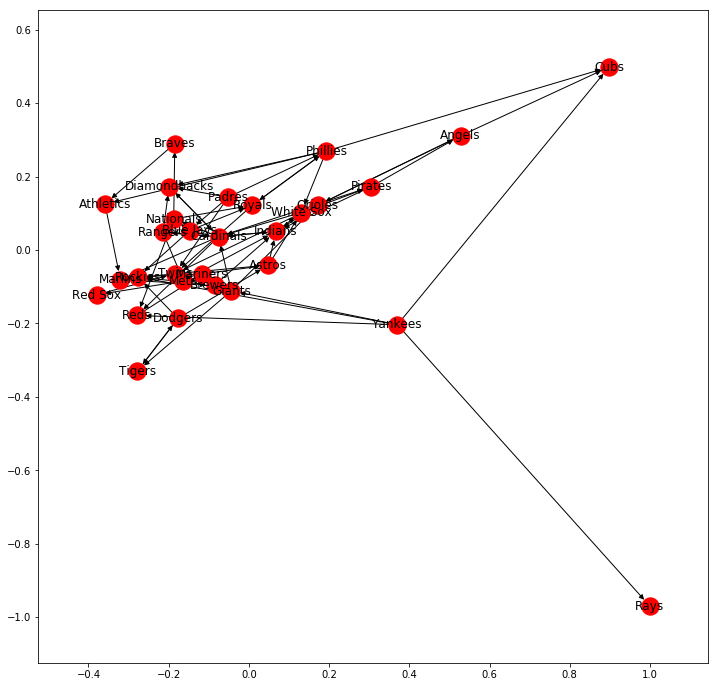

In [3]:
edges = data[(data['target']!='retired')&(data['target']!=data['Team'])][['Team', 'target']]
edges['label'] = edges['Team'] + "-" + edges["target"]
weights = edges['label'].value_counts()

count = 0
unconnected = nx.DiGraph()
unconnected.add_nodes_from(data['Team'].unique())
for t1, t2 in product(sorted(edges['Team'].unique()), repeat=2):
    if t1 == t2: continue
    elif t1+'-'+t2 not in weights.index:
        count += 1
        unconnected.add_edge(t1,t2)
        print(t1+'-'+t2)
plt.figure(figsize=(12,12))
nx.draw_networkx(unconnected, nx.spring_layout(unconnected))
plt.show()

In [16]:
count

66

In [5]:
def plot_graph(cutoff=0):
    g = nx.DiGraph()
    g.add_nodes_from(data['Team'].unique())
    for edge,w in zip(weights.index, weights):
        i,j = edge.split('-')
        if w > cutoff:
            g.add_edge(i,j,weight=w)
    plt.figure(figsize=(15,15))
    nx.draw_networkx(g, nx.circular_layout(g))
    plt.show()
    return g

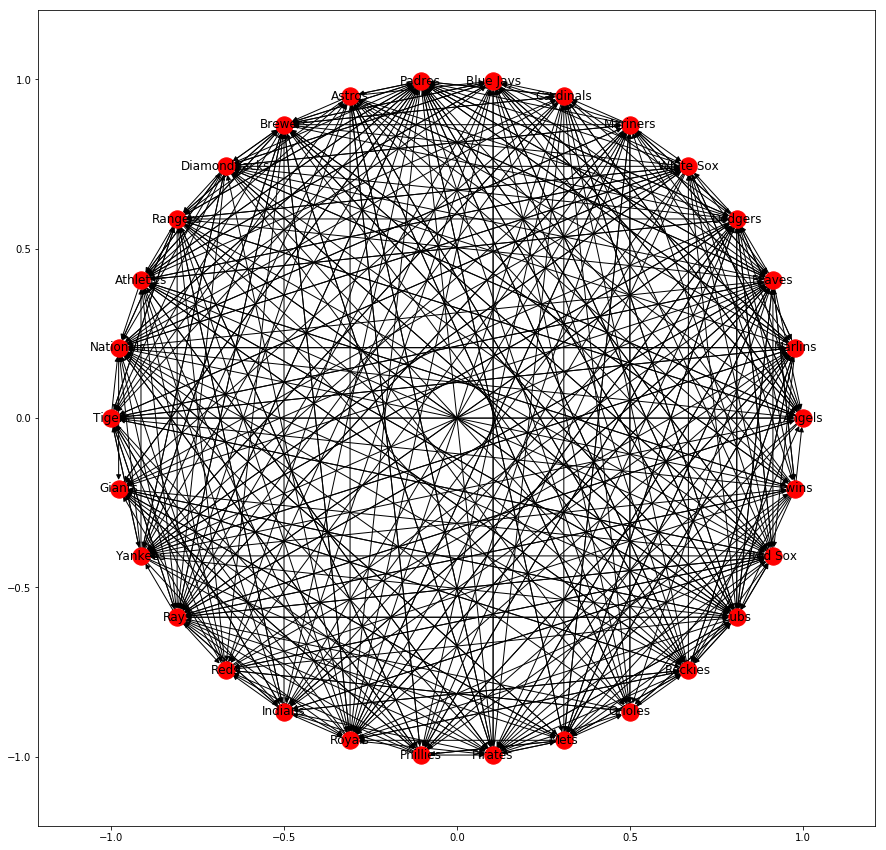

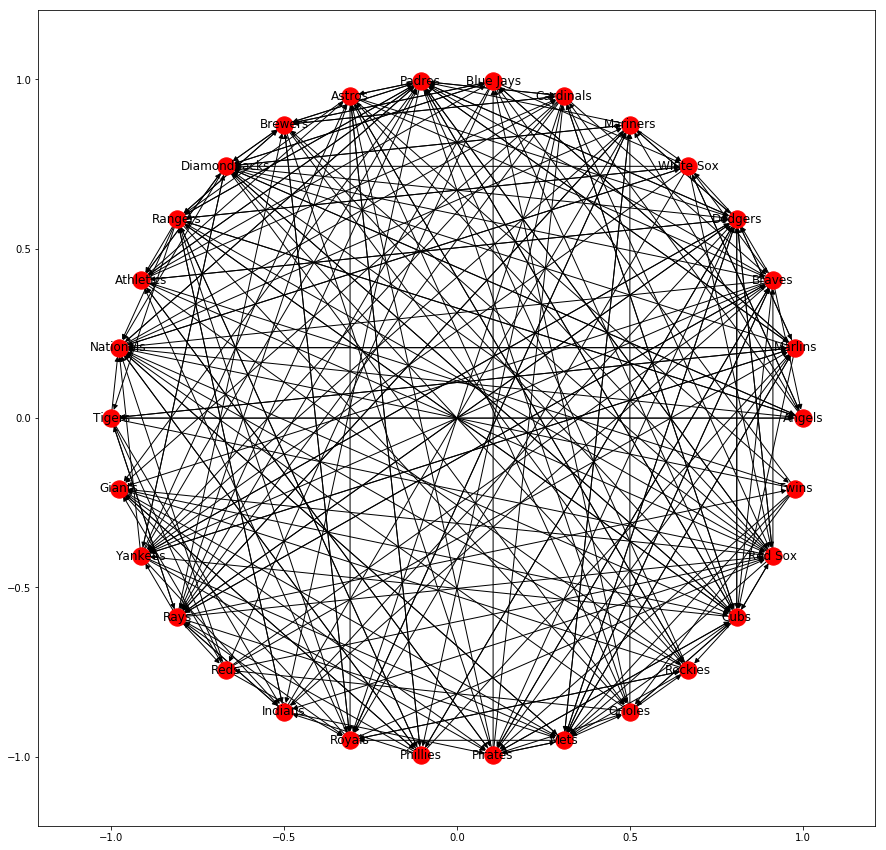

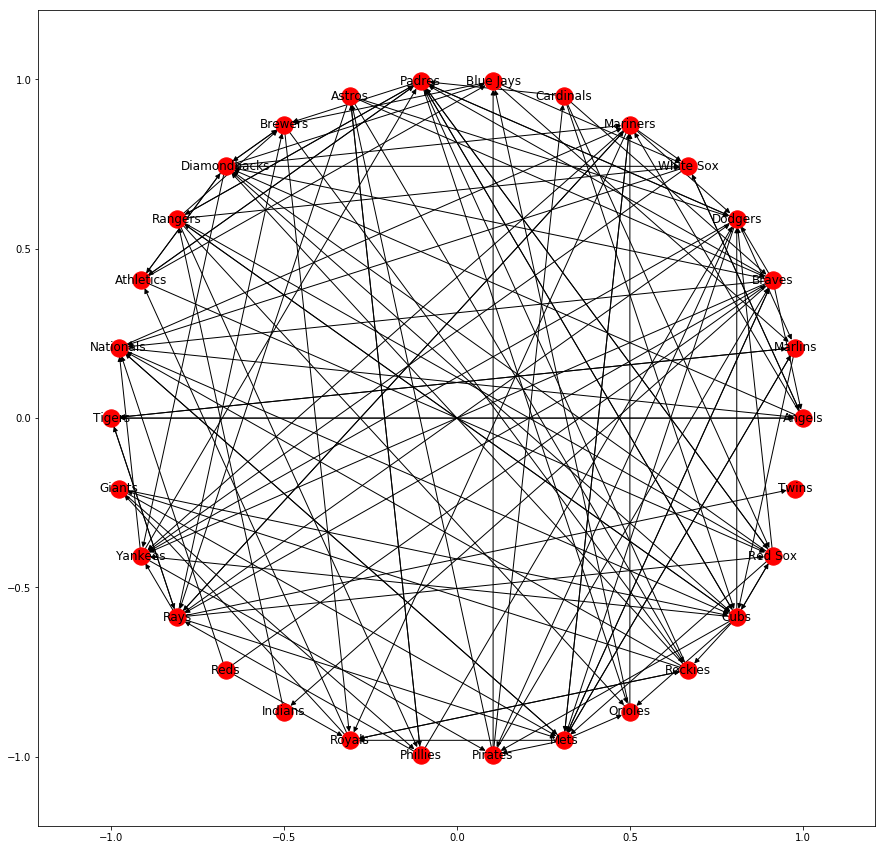

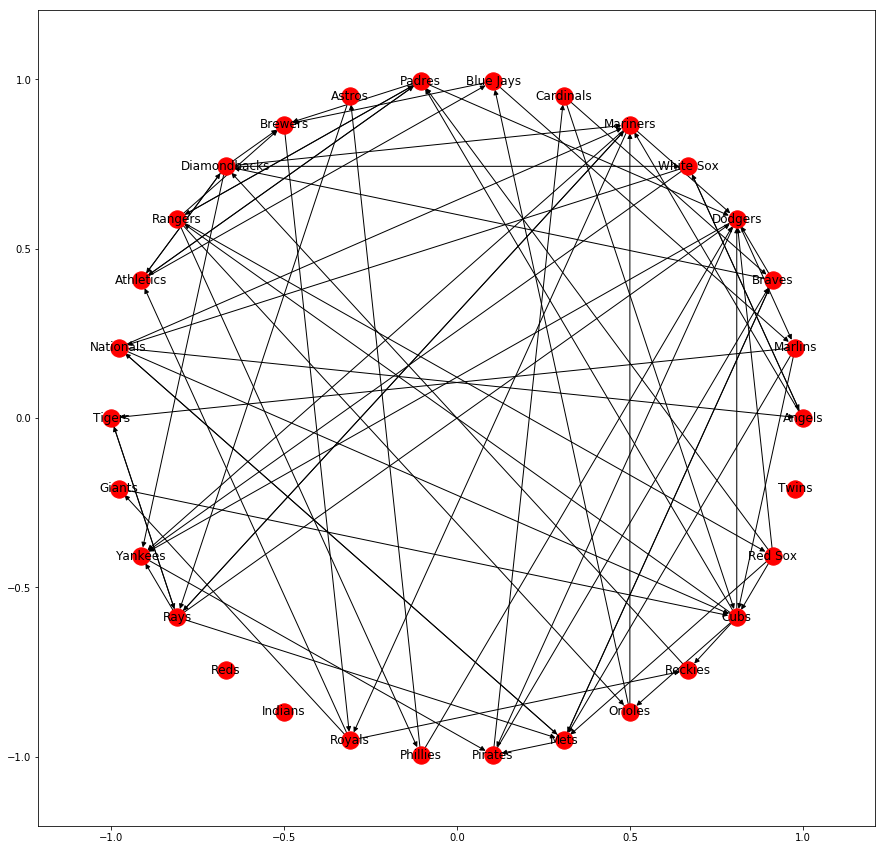

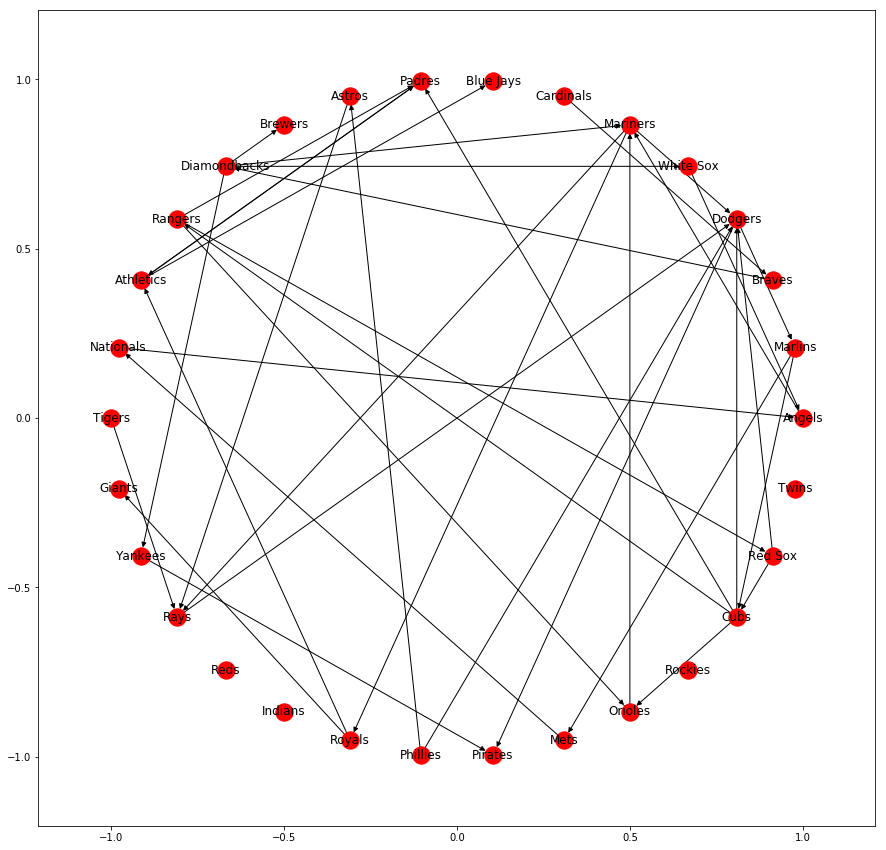

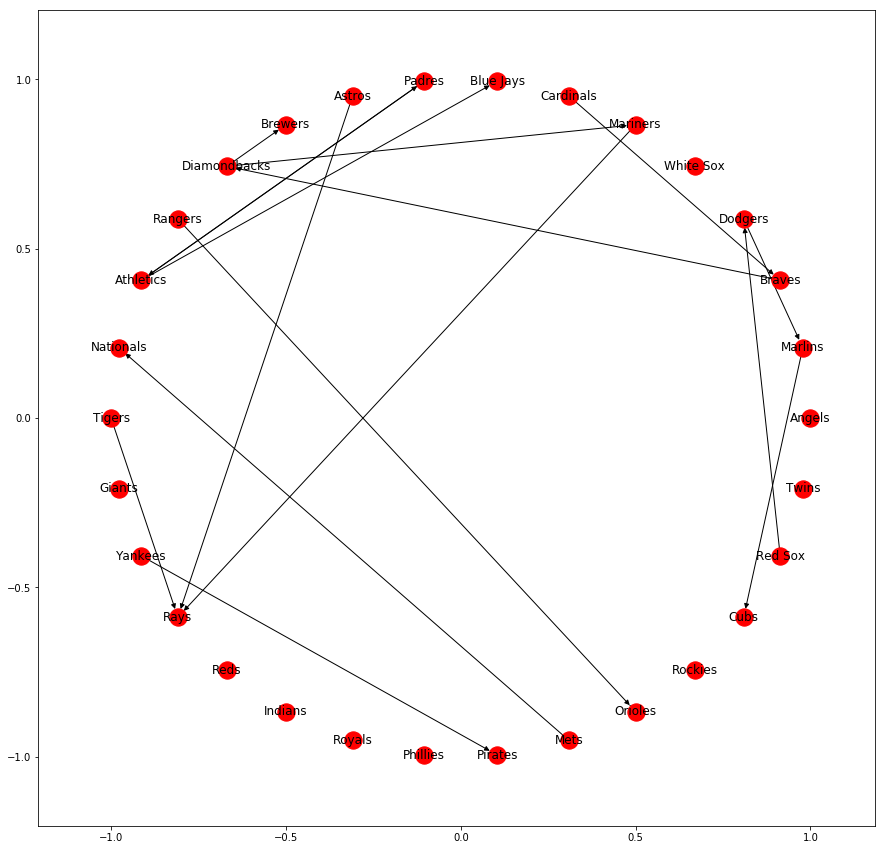

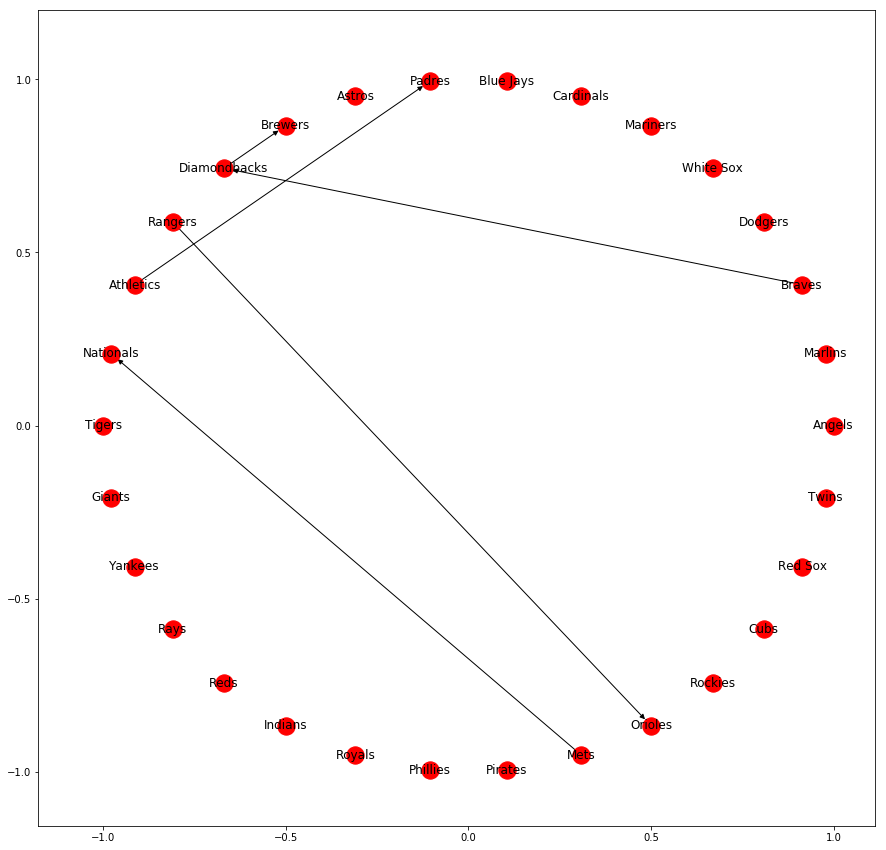

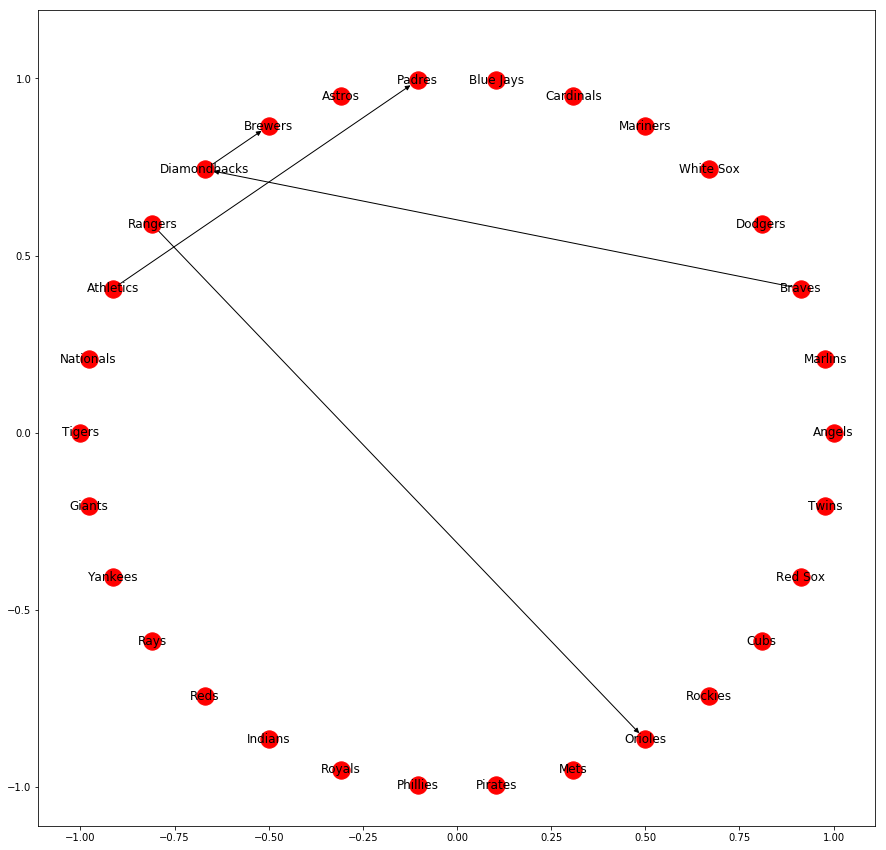

In [8]:
for i in range(2,10):
    plot_graph(i)

In [5]:
edges
in_dct = defaultdict(int)
out_dct = defaultdict(int)

for row in edges.values:
    in_dct[row[1]] += 1
    out_dct[row[0]] += 1
in_dct


defaultdict(int,
            {'Angels': 69,
             'Astros': 66,
             'Athletics': 80,
             'Blue Jays': 81,
             'Braves': 86,
             'Brewers': 86,
             'Cardinals': 64,
             'Cubs': 102,
             'Diamondbacks': 80,
             'Dodgers': 105,
             'Giants': 76,
             'Indians': 62,
             'Mariners': 85,
             'Marlins': 81,
             'Mets': 86,
             'Nationals': 90,
             'Orioles': 76,
             'Padres': 110,
             'Phillies': 72,
             'Pirates': 87,
             'Rangers': 75,
             'Rays': 93,
             'Red Sox': 88,
             'Reds': 59,
             'Rockies': 69,
             'Royals': 83,
             'Tigers': 70,
             'Twins': 54,
             'White Sox': 72,
             'Yankees': 85})

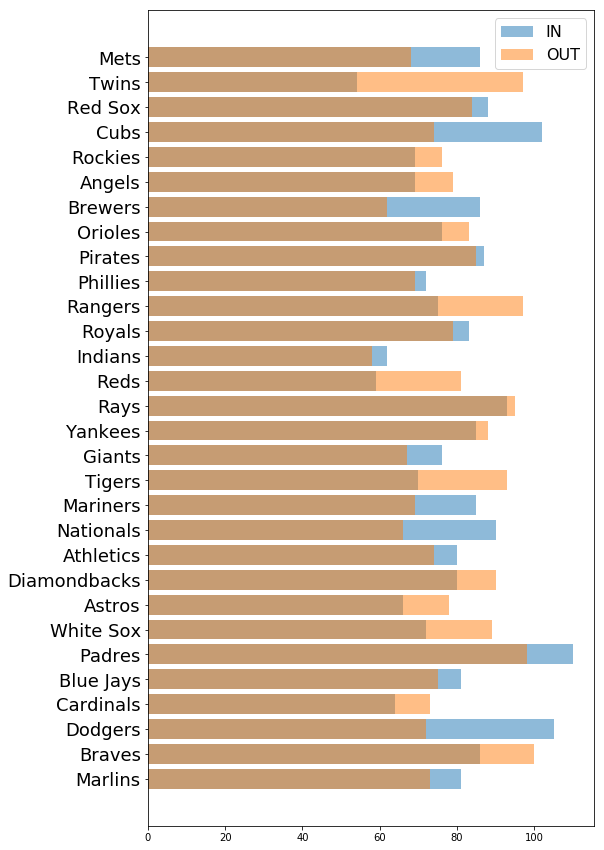

In [8]:
plt.figure(figsize=(8, 15))
#plt.subplot(121)
#plt.bar(range(len(in_dct)),np.array(list(in_dct.values()))-  np.array(list(out_dct.values())), alpha=0.5, label="IN")
plt.barh(range(len(in_dct)), list(in_dct.values()), alpha=0.5, label="IN")
plt.barh(range(len(in_dct)), list(out_dct.values()), alpha=0.5, label="OUT")
plt.yticks(range(len(in_dct)), in_dct.keys(), fontsize=18)
plt.legend(fontsize=16)
#plt.subplot(122)
#plt.bar(range(len(in_dct)),out_dct.values())
#plt.xticks(range(len(in_dct)), out_dct.keys(), rotation="vertical")
plt.show()

## Predict on just Innings and Games

In [ ]:
from networkx.algorithms import community
communities_generator = community.k_clique_communities(nx.to_undirected(g), 8)
top_level_communities = next(communities_generator)
#next_level_communities = next(communities_generator)
print(sorted(top_level_communities))
#print(sorted(map(sorted, next_level_communities)))

In [ ]:
for c in nx.strongly_connected_components(plot_graph(4)):
    print(c)

In [ ]:
print(g.get_edge_data('Red Sox', 'Yankees'))
print(g.get_edge_data('Yankees', 'Red Sox'))

In [ ]:
tree = nx.minimum_spanning_tree(nx.to_undirected(g))
nx.draw_networkx(tree)
plt.show()

In [ ]:
players = data[(data['target']=='Athletics')&(data['Team']=='Padres')]['playerid']

In [ ]:
data[data['playerid'].isin(players.values)].sort_values(by=['playerid', 'Season'])[['Name', 'Season', 'Team', 'Leave', 'Pos']]

In [ ]:
g = plot_graph()

In [11]:
edges = data[(data['target']!='retired')&(data['target']!=data['Team'])][['Team', 'target']]
#edges = data[(data['target']!=data['Team'])][['Team', 'target']]

with open("../data/team-team.txt", 'w') as f:
    f.write("To_team,From_team\n")
    for idx in edges.index:
        #print(edges[edges.index==idx][['Team', 'target']].values[0])
        f.write("{},{}\n".format(*edges[edges.index==idx][['target', 'Team']].values[0]))

In [12]:
team_rank("../data/team-team.txt")

([0.03522533951767606,
  0.03518540795870863,
  0.03450486102435501,
  0.03445843100414713,
  0.03445104391547337,
  0.03444616000547859,
  0.034396350875492095,
  0.03435612224924414,
  0.03430294785389554,
  0.034301828743804386,
  0.034262944079641366,
  0.03375785578696265,
  0.033570206532767634,
  0.03353757517807351,
  0.03352369612641132,
  0.03351647969616651,
  0.03350842878083732,
  0.03340657264315874,
  0.033403648972971815,
  0.0327595988963873,
  0.032745161410343324,
  0.03271719931898867,
  0.03257004236497121,
  0.032554902901004566,
  0.03248870115256696,
  0.0317928445431627,
  0.0316487122910274,
  0.03155344388160176,
  0.0309621798048112,
  0.03009131248986915],
 ['Padres',
  'Yankees',
  'Mariners',
  'Red Sox',
  'Braves',
  'Dodgers',
  'Mets',
  'Rays',
  'Rangers',
  'Blue Jays',
  'Giants',
  'Brewers',
  'Angels',
  'Athletics',
  'Tigers',
  'Orioles',
  'Pirates',
  'Phillies',
  'Nationals',
  'White Sox',
  'Marlins',
  'Astros',
  'Royals',
  'Cubs',
